# Super Resolution Generative Adversarial Network (SRGAN) using CelebA Dataset

## Introduction

This program will train a model to generate realistic super-resolution (SR) images, provided a dataset of high-resolution (HR) images which are downscaled to low-resolution (LR) images for training. If desired, you can skip the training and go straight to SR image generation by loading the pre-trained model `generatorX.h5` included in the repository. The model is optimized for SR image generation of human faces.

To train the model yourself:
1. Download the dataset from [here.](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ)
2. Extract the images to `SRGAN/datasets/img_align_celeba/<000001.jpg,  000002.jpg,  etc.>`
3. Run the first two cells in the `Training` section.
4. To start training from scratch (epoch 0), run the third cell. To resume training from a checkpoint, run the next cell instead. (Note: on a Nvidia RTX 2080 Super GPU, training took ~15 hours for 30000 epochs.)
5. Run the final cell in the `Training` section to save the model.

To generate SR images from LR images:
1. Run the cell in the `Loading a Model` section.
2. Run all cells in the `Generation` section.
3. To generating your own SR images, move an HR .jpg file into the same directory as this notebook and adjust the filepath in the `rescale_img` examples.

## Training

In [ ]:
import keras.backend as K
from keras.layers import BatchNormalization, Add, PReLU, Input, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
import cv2
import imageio
import regex as re
import pickle

In [ ]:
# Define the SRGAN class and methods.

class SRGAN():
    def __init__(self, load_weights=False):
        """
        Class initialization.
        
        ==Input==
          self object.
          load_weights: whether or not to continue training from a checkpoint.
        
        ==Output==
          Instantiates self parameters and builds vgg, generator, discrimator, and combined models.
        """
        
        # Input shape of images
        self.channels = 3                        # (H, W, RGB)
        self.lr_height = 64                      # LR height
        self.lr_width = 64                       # LR width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = 256                     # HR height = LR height upscaled by factor of 4
        self.hr_width = 256                      # HR width = LR width upscaled by factor of 4
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)
        
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16
        
        optimizer = Adam(0.0002, 0.5)  # original parameters        
        
        # Utilize a pre-trained VGG19 model to obtain perceptual content loss rather than pixel-wise loss.
        #    Specifically, the VGG19 model will extract image features from the original HR image and the
        #    generated HR image, and seek to minimize the mean-squared error between them.
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        
        # Utilize data_loader.py file to load in our dataset
        self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width))
        
        # Calculate output shape of discriminator (PatchGAN). This is so penalizations will only occur occur
        #    in local image patches.
        patch = int(self.hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of generator and discriminator
        self.gf = 64
        self.df = 64

        # Build and compile the discriminator. See build_discriminator function for more details.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy']) 
        
        # Build the generator. See build_generator function for more details.
        self.generator = self.build_generator()

        
        # Load model weights from previous checkpoint, if desired.
        self.checkpoint_epoch_number = 0        
        if load_weights:            
            
            # Try to get epoch number of most recent checkpoint, if available
            try:
                filename = os.listdir('saved_model/')[1]
                regex = re.compile(r'\d+')            
                self.checkpoint_epoch_number = regex.findall(filename)[0]
            except:
                # If there are no saved models, keep self.checkpoint_epoch_number equal to 0
                pass
            
            print(f'Loading checkpoints from epoch {self.checkpoint_epoch_number}...')            
            self.generator.compile(loss='binary_crossentropy', optimizer=Adam())
            self.generator.load_weights(f'saved_model/generator{self.checkpoint_epoch_number}.h5')            
            self.discriminator.load_weights(f'saved_model/discriminator{self.checkpoint_epoch_number}.h5')
            
        else:
            # Remove any existing model weight files if starting training from epoch 0.
            for file in os.listdir('saved_model/'):
                if file != 'generatorX.h5':
                    os.remove(f'saved_model/{file}')
        
        # Define HR and LR image inputs.
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate HR image from LR image.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated image
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated HR images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)

        
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features based on the shape of our HR image.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model containing image features based on VGG19.
        """
        vgg = VGG19(weights="imagenet")
        # The goal here is to set the output of the pre-trained VGG19 model equal to the output of its
        #    third block, so that image features for 256 nodes are obtained (matching our HR image shape).
        #    See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)   
    
    
    def build_generator(self):
        """
        Builds the generator neural network.
        
        ==Input==
          self object.
        
        ==Output==
          Returns a Keras model including the input LR image, and a generated HR image.
        """

        def residual_block(layer_input, filters):
            """
            Defines the standard structure of the residual blocks.
            
            ==Input==
              layer_input: the network layer to process residuals from.
              filters: number of filters for Conv2D layers.
              
            ==Output==
              d: An element-wise sum of the entire block.
            """
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = PReLU(shared_axes=[1,2])(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """
            Defines the standard structure of the upscaling blocks.
            
            ==Input==
              layer_input: the network layer to process upscaling from.
              
            ==Output==
              u: An array representing the upscaled image.
            """
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
            u = PReLU(shared_axes=[1,2])(u)
            return u

        # LR image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = PReLU(shared_axes=[1,2])(c1)

        # Propogate through 16 residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate HR output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    
    def build_discriminator(self):
        """
        Builds the discriminator neural network.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model including the input image and the resulting image classification based on
              sigmoid activation (i.e. real or fake image decision).
        """        

        def d_block(layer_input, filters, strides=1, bn=True):
            """
            Defines the standard structure of the recurring discriminator blocks.
            
            ==Input==
              layer_input: the network layer to process discriminator layers from.
              filters: number of filters for Conv2D layers.
              strides: number of strides for Conv2D layers.
              bn: whether or not to include a BatchNormalization layer.
              
            ==Output==
              d: An array representing the input image after all previous layer processing.              
            """
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input image
        d0 = Input(shape=self.hr_shape)

        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)

        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity) 

    
    def train(self, epochs, batch_size=1, sample_interval=50):
        """
        Train the discriminator and generator.
        
        ==Input==
          epochs: number of epochs over which to train the model.
          batch size: number of images to train at a time.
          sample_interval: how frequently to compile images for comparison.
          
        ==Output==
          Updates the weights and biases in self.discriminator and self.generator after each epoch.
          Compiles images for comparison in the images/img_align_celeba folder every <sample_interval> epochs.
        """
        
        start_time = datetime.datetime.now()
        
        # Initialize empty generator loss history list if starting training from epoch 0
        if self.checkpoint_epoch_number == 0:
            g_loss_list = []
        else:
            try:
                g_loss_list = pickle.load(open('pickles/g_loss_list.pkl', 'rb'))
            except:
                pass
        
        for epoch in range(0 + int(self.checkpoint_epoch_number), epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)
            
            # Generate HR image from LR image. (random)
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminator (original images = real / generated = fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)
            
            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generator
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])            
            # g_loss format:  ['loss', 'model_2_loss', 'model_1_loss']
            g_loss_list.append(g_loss)
            
            # Plot the progress
            elapsed_time = datetime.datetime.now() - start_time
            print (f'Epoch {epoch} elapsed time: {elapsed_time}.  Generator loss: {g_loss}')
            
            # If at save interval, save generated image samples, pickle, and model weights (if applicable)
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                pickle.dump(g_loss_list, open('pickles/g_loss_list.pkl', 'wb'))                
                self.generator.save_weights(f'saved_model/generator{epoch}.h5')
                self.discriminator.save_weights(f'saved_model/discriminator{epoch}.h5')                
                
                try:
                    os.remove(f'saved_model/generator{epoch-50}.h5')
                    os.remove(f'saved_model/discriminator{epoch-50}.h5')
                except:
                    pass  
        
        return g_loss_list
                
    def sample_images(self, epoch):
        """
        Compile two rows of LR/SR/HR images for comparison over all epochs.
        
        ==Input==
          epoch: the epoch number corresponding to the images being compiled.
          
        ==Output==
          Image files created in the images/img_align_celeba folder.
        """
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)

        imgs_hr, imgs_lr = self.data_loader.load_data(batch_size=2, is_testing=True)
        imgs_sr = self.generator.predict(imgs_lr)
        
        # Rescale image RGB values from 0 to 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        imgs_sr = 0.5 * imgs_sr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5
        
        # Save generated images and the high resolution originals
        titles = ['Input LR Image', 'Generated SR Image', 'Original HR Image']
        r, c = 2, 3
        fig, axs = plt.subplots(r, c, figsize=(12, 12))
        cnt = 0
        for row in range(r):
            for col, image in enumerate([imgs_lr, imgs_sr, imgs_hr]):
                
                # Resize image to original dimensions
                axs[row, col].imshow(cv2.resize(image[row], (178, 218)))
                
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("images/%s/%d.png" % (self.dataset_name, epoch))
        plt.close()    

In [ ]:
# Train from epoch 0 (do not load checkpoint)
gan = SRGAN()
g_loss_list = gan.train(epochs=30001, batch_size=1, sample_interval=50)

In [ ]:
# Load checkpoint and train starting at corresponding epoch
gan = SRGAN(load_weights=True)
g_loss_list = gan.train(epochs=30001, batch_size=1, sample_interval=50)

In [5]:
# Save a fully trained model
gan.generator.save('saved_model/generatorX.h5')

## Loading a Model

In [ ]:
# Run this cell to load the fully trained model

a = load_model('saved_model/generatorX.h5', compile=False)

## Generation

In [5]:
def rescale_img(img_path):
    """
    Rescale input images before prediction (generation) in order to meet the expected input shape and
        value range of the generator model.
    
    ==Input==
      img_path: filepath to the HR .jpg input image relative to this notebook file.
      
    ==Output==
      img_lr: rescaled LR image.
      img_sr: generated SR image.
      img_hr: original HR image.      
    """
    img = imageio.imread(img_path, pilmode='RGB').astype(float)
    
    low_h, low_w = int(256 / 4), int(256 / 4)

    img_res = (178, 218)  # Image resolution of original HR images in dataset
    img_hr = cv2.resize(img, img_res)
    img_lr = cv2.resize(img, (low_w, low_h))
        
    img_hr = np.array(img_hr) / 127.5 - 1.
    img_lr = np.array(img_lr) / 127.5 - 1.    
    
    # Expand dimensions to match generator's expected input dimensions, and predict
    img_lr2 = np.expand_dims(img_lr, axis=0)
    img_sr = a.predict(img_lr2)[0]
    
    # Rescale image RGB values from 0 to 1
    img_lr = 0.5 * img_lr + 0.5
    img_sr = 0.5 * img_sr + 0.5
    img_hr = 0.5 * img_hr + 0.5
    
    # Resize img_lr and img_sr to match the original HR aspect ratio.
    img_lr = cv2.resize(img_lr, img_res)
    img_sr = cv2.resize(img_sr, img_res)    
    
    return img_lr, img_sr, img_hr

In [6]:
def plot_image(img_lr, img_sr, img_hr):
    """
    Given numpy arrays representing images, plot each corresponding image.
    
    ==Input==
      img_lr: numpy array of LR image.
      img_sr: numpy array of SR image.
      img_hr: numpy array of HR image.
    
    ==Output==
      A plot containing each image.
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_lr)
    axs[0].set_title('Input LR Image')
    axs[0].axis('off')
    axs[1].imshow(img_sr)
    axs[1].set_title('Generated SR Image')
    axs[1].axis('off')
    axs[2].imshow(img_hr)
    axs[2].set_title('Original HR Image')
    axs[2].axis('off')
    return

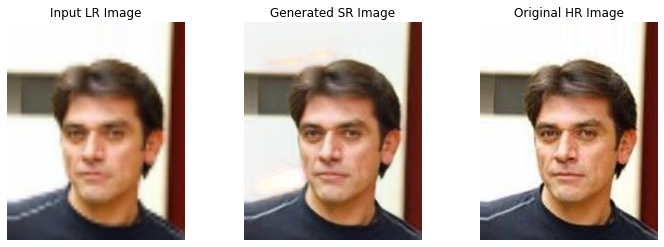

In [7]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/024324.jpg')
plot_image(img_lr, img_sr, img_hr)

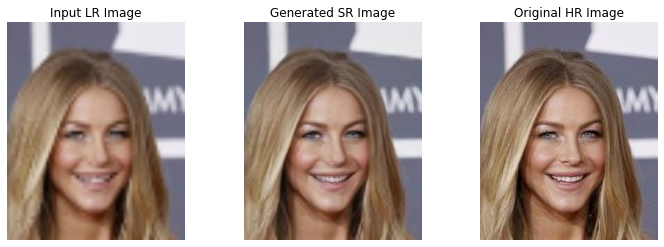

In [8]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130869.jpg')
plot_image(img_lr, img_sr, img_hr)